In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/usedcars_with_missing_values.csv")

In [3]:
df['year'] = df['year'].astype('category')

In [4]:
df

,year,model,price,mileage,color,transmission
0,2011,NaN,21992.0,7413.0,Yellow,AUTO
1,2011,SEL,20995.0,10926.0,Gray,AUTO
2,2011,SEL,19995.0,7351.0,Silver,AUTO
3,2011,SEL,17809.0,11613.0,Gray,AUTO
4,2012,SE,17500.0,8367.0,White,AUTO
...,...,...,...,...,...,...
145,2006,SES,6200.0,95000.0,Silver,AUTO
146,2002,SE,5995.0,87003.0,Red,AUTO
147,2000,SE,5980.0,96841.0,Red,AUTO
148,2001,SE,4899.0,151479.0,Yellow,AUTO


## Clean data

In [5]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
df_dummy = pd.get_dummies(df)
df_dummy = df_dummy.dropna()
df_dummy = df_dummy.reset_index(drop = True)

In [7]:
outcomename = 'price'
X = df_dummy.drop(columns = outcomename)
Y = df_dummy[outcomename]

In [8]:
# class create_model:
#     def __init__(self, model_name, test_size, X, Y):
#         self.model_name = model_name
#         self.test_size = test_size
#         self.X = X
#         self.Y = Y
    
#     def model(self):
#         self.model = self.model_name
#         self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.Y, test_size=self.test_size)
#         return self.model.fit(self.X_train, self.Y_train)
    
#     def r2_score(self):
#         print(self.model.score(self.X_test, self.Y_test))

In [9]:
class create_model:
    def __init__(self, model_name, test_size, X, Y, n_splits=5):
        self.model_name = model_name
        self.test_size = test_size
        self.X = X
        self.Y = Y
        self.n_splits = n_splits
    
    def model(self):
        kf = KFold(n_splits = self.n_splits, shuffle = True)
        scores = []
        for train_index, test_index in kf.split(self.X):
            self.X_train, self.X_test = self.X.values[train_index], self.X.values[test_index]
            self.Y_train, self.Y_test = self.Y.values[train_index], self.Y.values[test_index]
            self.model_name.fit(self.X_train, self.Y_train)
            scores.append(self.model_name.score(self.X_test, self.Y_test))
        self.mean_score = sum(scores) / self.n_splits
        return self.model_name
    
    def r2_score(self):
        self.Y_pred = self.model_name.predict(self.X)
        self.r2 = r2_score(self.Y, self.Y_pred)
        # print("Mean K-fold R^2 score:", self.mean_score)
        # print("Overall R^2 score:", self.r2)
        # return(self.mean_score, self.r2)

In [10]:
linear_model = create_model(LinearRegression(), 0.1, X, Y, n_splits=5)

In [ ]:
kfold = []
r2score = []
for number in range(1000):
    linear_model.model()
    linear_model.r2_score()
    kfold.append(linear_model.mean_score)
    r2score.append(linear_model.r2)

The Overall R^2 score is slightly higher than the Mean K-fold R^2 score, suggested that the model is performing well on the test set as well as on the training set. It indicates that the model has learned to generalize well to new data, which is a desirable quality in a model.

(0.0, 1.0)

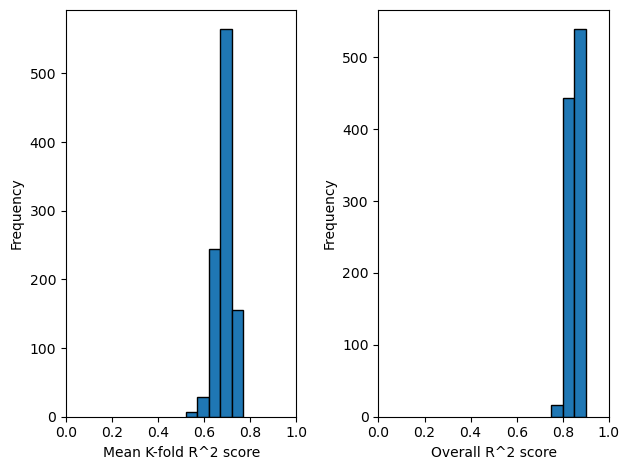

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# plt.hist(kfold, bins=30, range=(0, 1), alpha=0.5, color='green')
w = 0.05

fig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].hist(kfold, edgecolor='black', bins=np.arange(min(kfold), max(kfold) + w, w))
axs[0].set_xlabel('Mean K-fold R^2 score')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim([0, 1])

axs[1].hist(r2score, edgecolor='black', bins=np.arange(min(r2score), max(r2score) + w, w))
axs[1].set_xlabel('Overall R^2 score')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim([0, 1])